In [ ]:
import zipfile

# Extract FER zip file
zip_path = 'fer_data_set.zip'
extract_to = 'fer_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")


Extraction complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Set constants
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 50

train_dir = 'fer_data/train'
test_dir = 'fer_data/test'

In [ ]:
# Data Augmentation (balanced)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Compute class weights
y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Define Improved CNN Architecture
model = Sequential([
    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # Global pooling
    GlobalAveragePooling2D(),

    # Fully connected
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output
    Dense(7, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,216,583 (4.64 MB)

 Trainable params: 1,214,791 (4.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, min_lr=1e-6)


In [ ]:
# Train Model (with GPU optimization)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 131ms/step - accuracy: 0.1613 - loss: 2.1321 - val_accuracy: 0.1737 - val_loss: 2.0095 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.1769 - loss: 1.9277 - val_accuracy: 0.2561 - val_loss: 2.0381 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.2357 - loss: 1.8339 - val_accuracy: 0.2210 - val_loss: 1.8579 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.2567 - loss: 1.7607 - val_accuracy: 0.1799 - val_loss: 1.8943 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.3220 - loss: 1.6885 - val_accuracy: 0.3782 - val_loss: 1.6065 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.3692 - loss: 1.6325 - val_accuracy: 0.3407 - val_loss: 1.6618 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.4

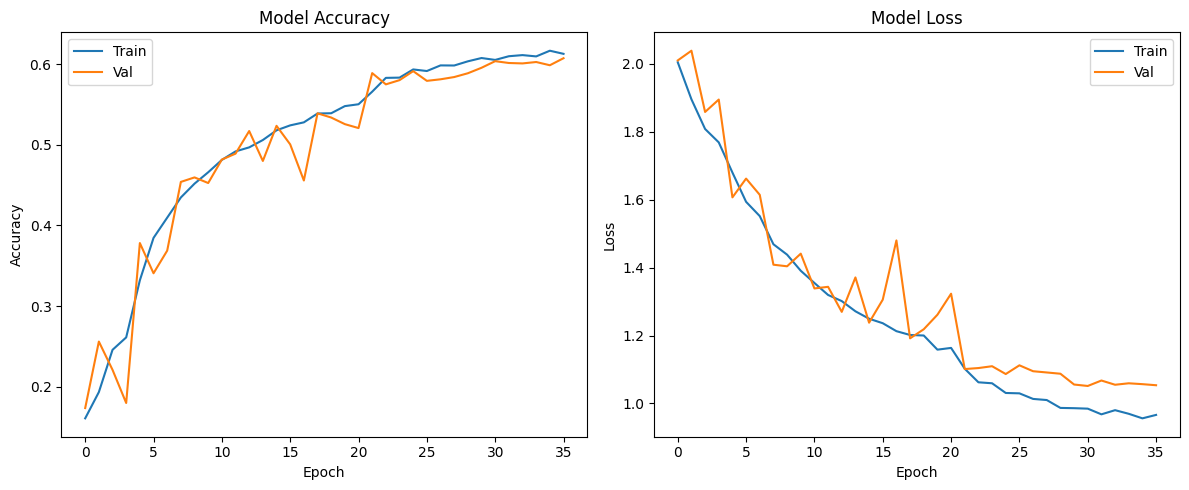

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

# Evaluate on Test Set
loss, acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {acc:.4f}")

# Classification Report
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5844 - loss: 1.0653

Test Accuracy: 0.6201
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
              precision    recall  f1-score   support

       angry       0.50      0.59      0.54       958
     disgust       0.37      0.68      0.48       111
        fear       0.49      0.29      0.36      1024
       happy       0.88      0.82      0.85      1774
     neutral       0.54      0.66      0.60      1233
         sad       0.52      0.45      0.48      1247
    surprise       0.68      0.83      0.75       831

    accuracy                           0.62      7178
   macro avg       0.57      0.62      0.58      7178
weighted avg       0.62      0.62      0.61      7178



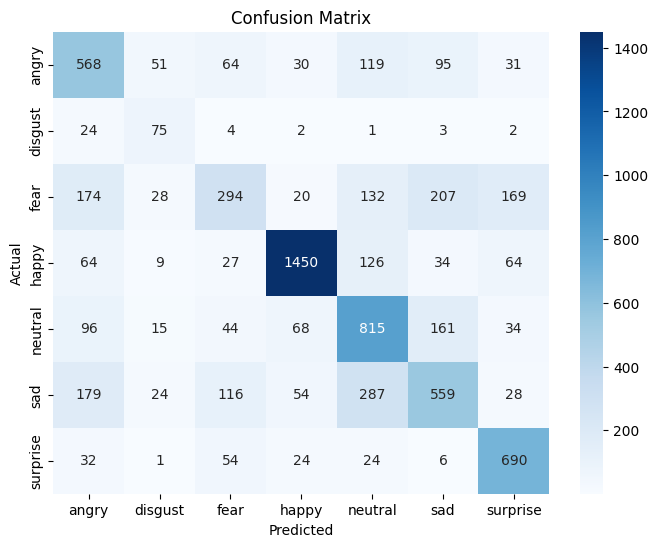

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save model
model.save("fer_cnn_model.h5")
print("Model saved as fer_cnn_model.h5")

Model saved as fer_cnn_model.h5


Saving image_trial.jpg to image_trial (5).jpg


Saving image_trial.jpg to image_trial (6).jpg


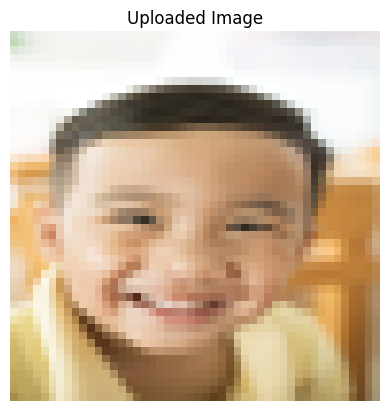

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predicted Emotion: Happy


In [ ]:
# Install necessary libraries
!pip install tensorflow keras opencv-python

#Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image

# Upload saved model (.h5 file)
uploaded_model = files.upload()  # Upload fer_cnn_model.h5
model = load_model('fer_cnn_model.h5')

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Upload an image for prediction
uploaded_image = files.upload()  # Upload a face image

# Preprocess image
for fname in uploaded_image.keys():
    # Read image in color
    img = Image.open(fname).convert('RGB')  # convert to RGB
    img = img.resize((48, 48))  # FER dataset standard input size
    img_array = np.array(img)
    plt.imshow(img_array) # Display color image
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Normalize and reshape for model input
    img_array = img_array / 255.0
    img_array = img_array.reshape(1, 48, 48, 3) # Reshape for 3 channels

    # Step 7: Predict emotion
    prediction = model.predict(img_array)
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    print(f"Predicted Emotion: {predicted_emotion}")